# Introduction

MiniML is a personally customized set of functions designed for quick and easy testing of different machine learning models built mainly on the `scikit-learn` library. It includes one-function comparison of different model performance as well as automated grid search functionality. A model explainer via the `SHAP` library is also included for basic model interpretation and further analysis.

This notebook includes functions for regression models and uses a preloaded `scikit-learn` dataset to display sample output.

In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

import shap

from sklearn import datasets
from sklearn.model_selection import GridSearchCV

import warnings
import os
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

In [20]:
df = pd.DataFrame(datasets.load_boston()['data'])
df.columns = datasets.load_boston()['feature_names']

target = datasets.load_boston()['target']

df['target'] = target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# Data Cleaning

In [22]:
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer as SI

def my_imputer(df, mean=[], median=[], most_frequent=[], fv=np.nan):
    """
    Imputes missing values in the given list of columns
    
    Note: you may have to perform the transformation separately for
    different columns.
    
    Parameters
    ----------
    df : dataframe
    
    mean : list
        list of columns
    
    median : list
        list of columns
        
    most_frequent : list
        list of columns
        
    strategy : str
        impute values according to these:
            mean (default)
            median
            most_frequent : use this for categorical
    """
    if mean != []:
        for col_name in mean:
            imr = SI(strategy='mean', fill_value=fv)
            imputed_data = imr.fit_transform(df[[col_name]])
            df[col_name] = imputed_data
    
    if median != []:
        for col_name in median:
            imr = SI(strategy='median', fill_value=fv)
            imputed_data = imr.fit_transform(df[[col_name]])
            df[col_name] = imputed_data
    if most_frequent != []:    
        for col_name in most_frequent:
            imr = SI(strategy='most_frequent', fill_value=fv)
            imputed_data = imr.fit_transform(df[[col_name]])
            df[col_name] = imputed_data
    
    return df

def replace_trash(df, col, trash):
    """
    Replaces trash values (not nan) with the most frequent value
    in the column.
    
    Parameters
    ----------
    df : dataframe
    
    col : str
        column name of column with trash values
        
    trash : str, int
        whatever it is you want to replace
    """
    fill = df[col].value_counts().index[0]
    df[col].replace(trash, fill)
    df[col] = df[col].replace(trash, fill)
    
    return df

# Data Prep

In [23]:
def split_scale(df, target, split_ratio=0.25, random_state=0, stratify=False,
               scaler=None):
    """
    Scales and performs train_test_split on a dataframe containing
    feature and target columns. 
    
    Returns
    -------
    model_data : dict
        a dictionary of dataframes
    """
    num_data = df.select_dtypes(include=['int64', 'float64'])
    df_targ = num_data[target]
    df_feats = num_data.drop(target, axis=1)
    
    if stratify:
        stratify=df
    else:
        stratify=None

    X_train, X_test, y_train, y_test = train_test_split(df_feats, df_targ, 
                                                    test_size=split_ratio, 
                                                    random_state=random_state, 
                                                    stratify=stratify)
    if scaler == 'minmax':
        scaler_obj = MinMaxScaler()
    elif scaler == 'robust':
        scaler_obj = RobustScaler()
    elif scaler == 'standard':
        scaler_obj = StandardScaler()
    elif scaler == 'norm':
        scaler_obj = Normalizer(norm=lp)
    else:
        pass
    
    if scaler is not None:
        X_train = scaler_obj.fit_transform(X_train)
        X_test = scaler_obj.fit_transform(X_test)
    else:
        pass
    
    model_data = {'X_train': X_train, 
                  'X_test': X_test, 
                  'y_train':y_train, 
                  'y_test':y_test, 
                  'features':df_feats.columns}
    
    return model_data

In [25]:
model_data = split_scale(df, 'target', split_ratio=0.30, random_state=0,
           stratify=False, scaler=None)

In [35]:
model = KNeighborsRegressor()
model.fit(model_data['X_train'], model_data['y_train'])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [52]:
param_grids = {'learning_rate': [.2, 0.1, 0.05, 0.02, 0.01],
              'max_depth': [3, 4, 6, 10, 14],
              'min_samples_leaf': [2, 3, 4],
              'max_features': [.5,.3, .2] 
}   

est = GradientBoostingRegressor(n_estimators=400)
gs_cv = GridSearchCV(est, param_grids, n_jobs=-1).fit(model_data['X_train'], 
                                                      model_data['y_train'])
print(gs_cv.best_params_)

{'learning_rate': 0.2, 'max_depth': 4, 'max_features': 0.5, 'min_samples_leaf': 4}


# ML Models: 

## Basic

In [329]:
def quick_test(df, target_col, ratio=0.30, r_state=0, scaler='None'):
    """
    Displays a variety of machine learning models and their respective
    training and test scores. Feature importance is also displayed if 
    applicable.
    """
    names = ['KNeighborsRegressor',
                          'Linear SVM',
             'Decision Tree',
                    'Ridge',
                    'Lasso',
                    'GradientBoostingRegressor',
                    'RandomForestRegressor',
                    'AdaBoostRegressor',
                    'XGboost']

    regressors = [KNeighborsRegressor(),
                                    LinearSVR(),
                  DecisionTreeRegressor(),
                    Ridge(),
                    Lasso(),
                    GradientBoostingRegressor(),
                    RandomForestRegressor(),
                    AdaBoostRegressor(),
                    xgb.XGBRegressor()]

    model_data = split_scale(df, target_col, split_ratio=ratio, random_state=r_state,
               stratify=False, scaler=None)

    X_train = model_data['X_train']
    X_test = model_data['X_test']
    y_train = model_data['y_train']
    y_test = model_data['y_test']
    
    training_acc = []
    test_acc = []
    top_predictor = []
    
    for ml in regressors:
        model = ml
        mod_obj = model.fit(X_train, y_train)

        training_acc.append(model.score(X_train, y_train))
        test_acc.append(model.score(X_test, y_test))
        
        try:
            feature_importance = mod_obj.feature_importances_
            # feature_importance[np.argsort(feature_importance)[-1]]
            top_predictor.append(
                model_data['X_train'].columns[np.argsort(feature_importance)[-1]])
        except:
            top_predictor.append('N/A')
        
    df_out = pd.DataFrame({'Model': names, 'Train Acc': training_acc, 
                           "Test Acc": test_acc, 'Top Predictor': top_predictor})
    return df_out

In [362]:
params_gs = {
    'KNN':{'n_neighbors': [1,3, 5, 7, 9, 11, 13, 15]},
    'LogisticRegression L1': {'C': [1e-12, 1e-10, 1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75,
                         1, 1.5, 3, 5, 10]},
    'LogisticRegression L2': {'C': [1e-12, 1e-10, 1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75,
                         1, 1.5, 3, 5, 10]},
    'SVM L1': {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 500, 1000]},
    'SVM L2': {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 500, 1000]},
    'SVC RBF': {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 500, 1000], 
               'gamma': [1e-2,0.1, 1, 2, 3, 5, 10,
                        15, 20, 100, 500, 1000 ]},
    'SVC Poly': {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 500, 1000], 
                 'degree': [3],
                 'coef0': [0,5,10, 100]},
    'Random Forest': {'n_estimators': [100, 500, 1000], 
                      'max_features' : [None, 3, 5, 'auto'],
                      'max_depth' : list(range(3, 10))#+[None],
                     },
    'Decision Tree':{'max_depth' : range(3, 5)},
    'GBM': {'n_estimators': [100, 500, 1000], 
                      'max_features' :  [None, 3, 5, 'auto'],
                      'learning_rate': np.arange(0.1, 3, 0.3).tolist(),
                      'max_depth' : list(range(3, 10))#+[None],
                     },
    'Ridge': {'alpha': [1e-12, 1e-10, 1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75,
                         1, 1.5, 3, 5, 10]},
    'Lasso': {'alpha': [1e-12, 1e-10, 1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75,
                         1, 1.5, 3, 5, 10]},
    'Bayes_Gaussian': {'var_smoothing': [1e-12, 1e-10, 1e-9, 1e-8, 1e-4, 1e-3,0.1, 0.2,0.4, 0.75,
                         1] },
    'Ada Boost': {'learning_rate': np.arange(0.1, 3, 0.3).tolist(),
                  'n_estimators': [100, 500, 1000]},
    'XGBoost': {'learning_rate': np.arange(0.1, 3, 0.3).tolist(),
               'max_depth' : list(range(3, 7)),
               'n_estimators': [100, 300, 500]}
}

In [354]:
def grid_search_all(df, target_col, ratio=0.30, r_state=0, scaler='None'):
    """
    Displays a variety of machine learning models and their respective
    training and test scores. Feature importance is also displayed if 
    applicable.
    
    Uses GridSearch to find the best combination of hyper parameters
    listed in params_gs.
    
    This may take a while to run.
    """

    names = ['KNN',
             'SVM L2',
             'Decision Tree',
            'Ridge',
            'Lasso',
            'GBM',
            'Random Forest',
            'Ada Boost']

    model_list = [KNeighborsRegressor(),
                  LinearSVR(),
                  DecisionTreeRegressor(),
                    Ridge(),
                    Lasso(),
                    GradientBoostingRegressor(),
                    RandomForestRegressor(),
                    AdaBoostRegressor()]
    
    model_iter = list(zip(names, model_list))

    model_data = split_scale(df, target_col, split_ratio=ratio, random_state=r_state,
               stratify=False, scaler=None)

    X_train = model_data['X_train']
    X_test = model_data['X_test']
    y_train = model_data['y_train']
    y_test = model_data['y_test']
    
    training_acc = []
    test_acc = []
    top_predictor = []
    params = []
    
    for ml in model_iter:
        print(ml[0])
        model = ml[1]
        model.fit(X_train, y_train)
        model_out = GridSearchCV(model, param_grid = params_gs[ml[0]], iid=False)
        mod_obj = model_out.fit(X_train, y_train)
        
        
        training_acc.append(mod_obj.score(X_train, y_train))
        test_acc.append(mod_obj.score(X_test, y_test))
        params.append(mod_obj.best_params_)
        
        try:
            feature_importance = mod_obj.best_estimator_.feature_importances_
            # feature_importance[np.argsort(feature_importance)[-1]]
            top_predictor.append(
                model_data['X_train'].columns[np.argsort(feature_importance)[-1]])
        except:
            top_predictor.append('N/A')
        
    df_out = pd.DataFrame({'Model': names, 'Train Acc': training_acc, 
                           "Test Acc": test_acc, 'Top Predictor': top_predictor,
                          "Best Params": params})
    return df_out

In [355]:
grid_search_all(df, 'target')

KNN
SVM L2
Decision Tree
Ridge
Lasso
GBM
Random Forest
Ada Boost


,Model,Train Acc,Test Acc,Top Predictor,Best Params
0,KNN,0.648548,0.473386,N/A,{'n_neighbors': 7}
1,SVM L2,-0.934667,-0.781466,N/A,{'C': 0.1}
2,Decision Tree,0.851129,0.662887,RM,{'max_depth': 3}
3,Ridge,0.764475,0.672546,N/A,{'alpha': 0.1}
4,Lasso,0.764541,0.673195,N/A,{'alpha': 0.001}
5,GBM,1.000000,0.781104,LSTAT,"{'learning_rate': 0.1, 'max_depth': 7, 'max_fe..."
6,Random Forest,0.983837,0.784469,RM,"{'max_depth': 9, 'max_features': 5, 'n_estimat..."
7,Ada Boost,0.931046,0.726046,LSTAT,"{'learning_rate': 2.2000000000000006, 'n_estim..."


# Model Explainer: SHAP

In [155]:
shap_values = shap.KernelExplainer(model.predict, 
                                   model_data['X_train']).shap_values(model_data['X_train'])

Using 354 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [160]:
def explain_model(df_shap, df, simplify=False):
    """
    Uses SHAP to visualize feature importance. 
    
    Parameters
    ----------
    df_shap : numpy array
        generate with the code above. may take some time
        
    df : dataframe
        training or test data used to generate the shap values
        
    simplify : bool
        Displays a simplified version if simplify=True. 
    """
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
#     display(shap_v)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr'] > 0,
                               'red', 'blue')
    
    if simplify:
        # Plot bar
        shap_abs = np.abs(shap_v)
        k=pd.DataFrame(shap_abs.mean()).reset_index()
        k.columns = ['Variable','SHAP_abs']
        k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
        k2 = k2.sort_values(by='SHAP_abs',ascending = True)
        colorlist = k2['Sign']
        ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(8,6),legend=False)
        ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    else:
        # Plot Summary
        shap.summary_plot(shap_values, model_data['X_train'])

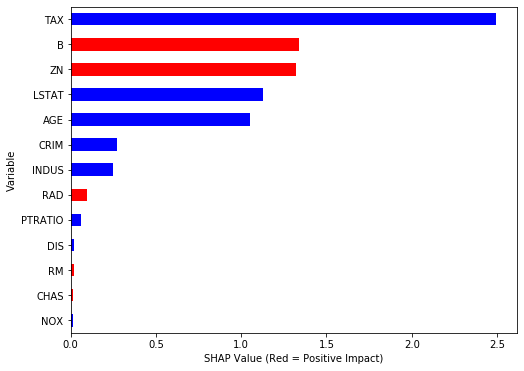

In [162]:
explain_model(shap_values, model_data['X_train'], True)

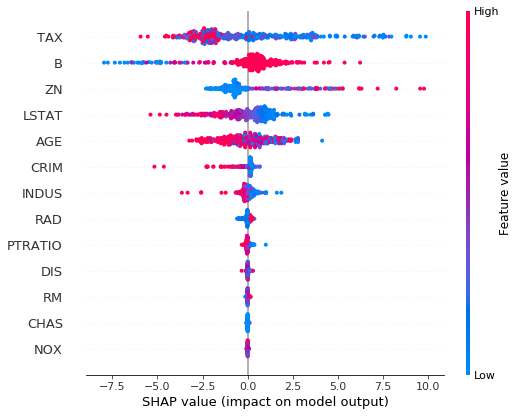

In [163]:
explain_model(shap_values, model_data['X_train'], False)

# References

SHAP: https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d